<a href="https://colab.research.google.com/github/rajy4683/EVAP2/blob/master/EVA4_SuperRes_SRGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Super Resolution with GANs



In [ ]:
!nvidia-smi

Sat Oct 10 05:38:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import numpy as np
import datetime
import os, sys
import glob
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline
# Set random seed for reproducibility
import random
manualSeed = 0xdeadbeef
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  3735928559


In [ ]:
MODEL_NAME = 'R1GAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#!cp /content/drive/My\ Drive/EVA4/Flying\ Birds.zip /content/FlyingBirds.zip
#!ls -1 /content/*zip |while read line; do unzip -q $line;done

# !cp /content/drive/My\ Drive/EVA4/Small\ QuadCopters.zip /content/SmallQuadCopters.zip
# !unzip -q /content/SmallQuadCopters.zip


#!cp /content/drive/My\ Drive/EVA4/S2GAN/allCars_wbg.tar.gz /content
#!tar -zxvf allCars_wbg.tar.gz
#!tar -zxvf allCars_wbg.tar.gz

!cp /content/drive/My\ Drive/EVA4/Flying\ Birds.zip /content/FlyingBirds.zip
!cp /content/drive/My\ Drive/EVA4/Large\ QuadCopters-20200723T085054Z-001.zip /content/LargeQuadCopters.zip
!cp /content/drive/My\ Drive/EVA4/Small\ QuadCopters.zip /content/SmallQuadCopters.zip
!cp /content/drive/My\ Drive/EVA4/Winged\ Drones-20200723T075457Z-001.zip /content/WingedDrones.zip
!cp -Rf /content/drive/My\ Drive/EVA4/SRGAN /content



!ls -1 /content/*zip |while read line; do unzip -q $line;done

Mounted at /content/drive


In [ ]:
import sys
sys.path.append("/content/drive/My Drive/EVA4/RekogNizer")
sys.path.append("/content/drive/My Drive/EVA4/")
sys.path.append("/content/SRGAN")

### Basic Data Cleaning

In [ ]:
!rm -rf /content/Winged\ Drones/*.txt
!rm -rf /content/Winged\ Drones/*.ipynb
!rm -rf /content/Winged\ Drones/*.svg

!rm -rf /content/Large\ QuadCopters/*.txt
!rm -rf /content/Large\ QuadCopters/*.ipynb
!rm -rf /content/Large\ QuadCopters/*.svg

!rm -rf /content/Small\ QuadCopters/*.txt
!rm -rf /content/Small\ QuadCopters/*.ipynb
!rm -rf /content/Small\ QuadCopters/*.svg

!rm -rf /content/Flying\ Birds/*.txt
!rm -rf /content/Flying\ Birdss/*.ipynb
!rm -rf /content/Flying\ Birds/*.svg


In [ ]:
%load_ext autoreload
%autoreload 2
from SRGAN import data_utils
import shutil
def handle_image_errors(file_list):
    crop_size = 100
    my_transform = data_utils.train_hr_transform(crop_size)
    for file_name in file_list:
        hr_image = Image.open(file_name)
        try:        
            transformed_img = my_transform(hr_image)
            #if(transformed_img.shape[0] < 3 or transformed_img.shape[0] > 3):
            #    raise Exception
        except Exception as e:
            print(e, file_name,hr_image.size)
            shutil.move(file_name, "/content/rejected_pics/")
            continue

if not os.path.exists("/content/rejected_pics/"):
    os.makedirs("/content/rejected_pics/")

train_dir_list = ["/content/Flying Birds","/content/Large QuadCopters", 
                  "/content/Small QuadCopters", "/content/Winged Drones"]

for train_dir_name in train_dir_list:
    handle_image_errors(glob.glob(train_dir_name+"/*"))

empty range for randrange() (0,0, 0) /content/Flying Birds/australian-magpie-preparing-to-fly-pic.jpg (150, 99)
empty range for randrange() (0,-75, -75) /content/Flying Birds/image8.png (24, 24)


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


empty range for randrange() (0,-16, -16) /content/Large QuadCopters/this-guy-skydived-using-a-mega-drone-and-its-harr-2-12924-1494889159-0.jpg (125, 83)
empty range for randrange() (0,-9, -9) /content/Small QuadCopters/OIP - 2020-07-21T024556.887.jpg (90, 90)
empty range for randrange() (0,-6, -6) /content/Small QuadCopters/OIP.48HpJXdyEUHuO8-IK77YJAHaEK.jpeg (166, 93)
empty range for randrange() (0,-13, -13) /content/Small QuadCopters/OIP.0tZOFuhpMDPYprQnkzB-QAHaDt.jpeg (173, 86)
empty range for randrange() (0,-6, -6) /content/Small QuadCopters/OIP.ej5bmjJV0Ut6Fcug3rBJ6AHaEK.jpeg (166, 93)
empty range for randrange() (0,-12, -12) /content/Small QuadCopters/OIP (61).jpg (130, 87)
empty range for randrange() (0,-24, -24) /content/Small QuadCopters/6fec6a8e6f9be9342da45b56263598d9.jpg (75, 75)
empty range for randrange() (0,-2, -2) /content/Small QuadCopters/OIP.ztnWbehUFlxPU-kPfyzGkQHaEK.jpeg (173, 97)
empty range for randrange() (0,0, 0) /content/Small QuadCopters/OIP (135).jpg (207, 9

In [ ]:
%load_ext autoreload
%autoreload 2
from SRGAN import data_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training with Upscale Factor=2

In [ ]:
!python SRGAN/train_lite.py --crop_size 100 --upscale_factor 2 --num_epochs 50 --batch_size 32

Run Identifier:103000cf22
# generator parameters: 586506
# discriminator parameters: 5215425
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:26<00:00, 20.9MB/s]
[1/1] Loss_D: 0.8675 Loss_G: 0.0217 D(x): 0.5434 D(G(z)): 0.3772:   3% 23/667 [00:14<04:34,  2.35it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[1/1] Loss_D: 0.7882 Loss_G: 0.0168 D(x): 0.6055 D(G(z)): 0.3593:   6% 42/667 [00:23<04:37,  2.26it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[1/1] Loss_D: 0.6513 Loss_G: 0.0105 D(x): 0.6881 D(G(z)): 0.3144:  22% 144/667 [01:16<07:

In [ ]:
!python SRGAN/train_lite.py --crop_size 100 --upscale_factor 2 --num_epochs 50 --batch_size 32

Run Identifier:6fd161e95e
# generator parameters: 586506
# discriminator parameters: 5215425
[1/1] Loss_D: 0.8274 Loss_G: 0.0174 D(x): 0.5832 D(G(z)): 0.3779:   5% 35/667 [00:17<04:42,  2.24it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[1/1] Loss_D: 0.7681 Loss_G: 0.0159 D(x): 0.6102 D(G(z)): 0.3527:   6% 42/667 [00:22<05:36,  1.86it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[1/1] Loss_D: 0.6234 Loss_G: 0.0107 D(x): 0.7109 D(G(z)): 0.2995:  19% 129/667 [01:12<04:01,  2.23it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA im

## Training with Upscale Factor = 4

In [ ]:
!python SRGAN/train_lite.py --crop_size 100 --upscale_factor 4 --num_epochs 10 --batch_size 32

Run Identifier:2deb120d9c
# generator parameters: 734219
# discriminator parameters: 5215425
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:12<00:00, 44.5MB/s]
  0% 0/667 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[1/1] Loss_D: 0.8586 Loss_G: 0.0363 D(x): 0.5242 D(G(z)): 0.3537:   2% 16/667 [00:11<08:11,  1.32it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[1/1] Loss_D: 0.5827 Loss_G: 0.0217 D(x): 0.7102 D(G(z)): 0.2692:   8% 54/667 [00:33<04:00,  2.55it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserW

In [ ]:
!python SRGAN/train_lite.py --crop_size 100 --upscale_factor 4 --num_epochs 30 --batch_size 32

Run Identifier:1dff8d3df9
# generator parameters: 734219
# discriminator parameters: 5215425
[1/1] Loss_D: 0.9216 Loss_G: 0.0753 D(x): 0.5000 D(G(z)): 0.3959:   1% 4/667 [00:05<18:46,  1.70s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[1/1] Loss_D: 0.7182 Loss_G: 0.0234 D(x): 0.6057 D(G(z)): 0.2746:   6% 43/667 [00:24<03:44,  2.78it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[1/1] Loss_D: 0.8174 Loss_G: 0.0168 D(x): 0.6373 D(G(z)): 0.4259:  15% 101/667 [00:55<03:51,  2.45it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA ima

## Training with Upscale Factor=8

In [ ]:
!python SRGAN/train_lite.py --crop_size 100 --upscale_factor 8 --num_epochs 50 --batch_size 32 --lr 2e-5

Run Identifier:34b7d4c995
# generator parameters: 881932
# discriminator parameters: 5215425
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:02<00:00, 261MB/s]
[1/1] Loss_D: 0.9329 Loss_G: 0.0845 D(x): 0.5086 D(G(z)): 0.4369:   3% 21/667 [00:14<04:29,  2.40it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[1/1] Loss_D: 0.6749 Loss_G: 0.0622 D(x): 0.6407 D(G(z)): 0.3117:  15% 99/667 [00:55<03:20,  2.83it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[1/1] Loss_D: 0.5923 Loss_G: 0.0546 D(x): 0.6844 D(G(z)): 0.2731:  21% 142/667 [01:18<03:4

## Sample results

The 3rd Image in the series is the SuperRes Image

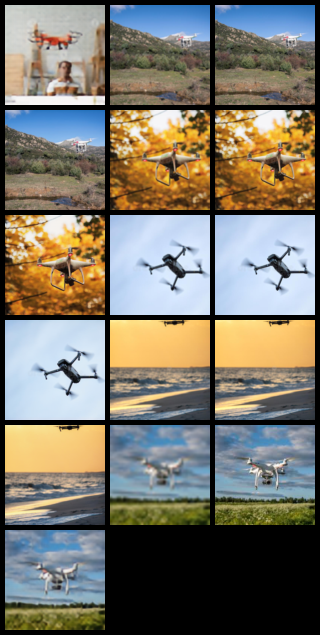

In [ ]:
Image.open("/content/training_results/SRF_4/epoch_63_index_6.png")